In [1]:
# The idea is to do a simple linear model of non-linear interactions between basic statistics. We will motivate these
# interactions based on some intuitions. For example, (mean / std) should influence the forecasting ability 
# different statistics, i.e. look at (mean / std) * mean. However, we do this for windows.

# A better basis is based on using r_i = (mean_window_i / mean_all) or r_i = (mean_window_i / (epsilon + mean_all)).
# Normally, one could estimate using the average of the mean_window_i (or some weighted average). However, when 
# r_i is large, one wants to replace mean_window_i by mean_all. So we are lead to trying basis functions such as
# f_i = exp(-K_i * r_i) * mean_window_i + (1 - exp(-K_i * r_i)) * mean_all, where K_i is a constant parameter that
# can be adjusted. First try finding optimal K_i that increase linear correlation between Y_mean and f_i.
# Also can try using logit functions of r_i or some other functions that is suggestive of a neural network.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

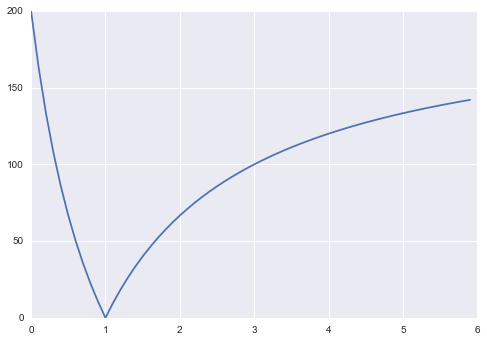

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [8]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_features(X, nWindows = 2, windowSize = 64):
    nSamples, nFeatures = X.shape
    # Make a view from X that is a 3d array of size (nSamples, windowSize, nWindows). This gives a view
    # of each window in X.
    X_window = nFeatures - 1 - np.arange(windowSize)[:, np.newaxis] - windowSize * np.arange(nWindows)
    X_window = X[:, X_window]
    
    # Now extract features for X and for each window.
    all_mean = np.mean(X, axis = 1, keepdims = True)
    features = all_mean.copy()
    newCols = np.mean(X_window, axis = 1) # window means
    features = np.hstack((features, newCols))
    
    return features

def window_weights(all_mean, window_means, k = 0.4, epsilon = 1e-6):
    weights = window_means / (epsilon + all_mean)
    weights = np.exp(-k * weights)
    return weights
    
def all_features(X, nWindows = 2, windowSize = 240, k = 0.4, epsilon = 1e-4):
    nSamples, nTimes = X.shape
    windFeatures = window_features(X, nWindows, windowSize)
    weights = window_weights(windFeatures[:,0].reshape(-1,1), windFeatures[:, 1:1+nWindows], k, epsilon)
    weightedFeatures = windFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
    weightedFeatures = weightedFeatures.reshape(nSamples, -1)
    windFeatures = np.hstack((windFeatures, weightedFeatures))
    return windFeatures

In [9]:
# Look at feature data.

newFeatures = window_features(X_train)
weights = window_weights(newFeatures[:, 0].reshape(-1,1), newFeatures[:, 1:3])
allFeatures = all_features(X_train)
print('newFeatures.shape = ', newFeatures.shape, '\tweights.shape = ', weights.shape, '\tallFeatures.shape = ', allFeatures.shape)

newFeatures.shape =  (65118, 3) 	weights.shape =  (65118, 2) 	allFeatures.shape =  (65118, 9)


(97192, 6)


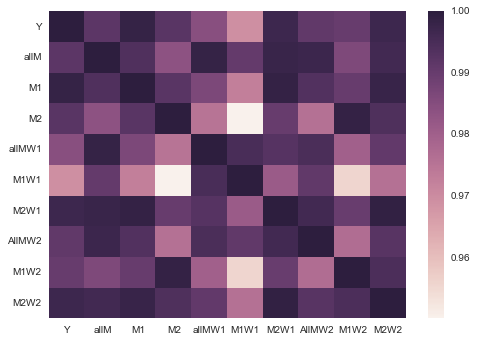

In [10]:
# Let's look at linear correlations.
nSamples, nTimes = X_trainvalid.shape
Y_mean = Y_trainvalid.mean(axis = 1, keepdims = True)
newFeatures = window_features(X_trainvalid)
weights = window_weights(newFeatures[:, 0].reshape(-1,1), newFeatures[:, 1:3])
weightFeatures = newFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
weightFeatures = weightFeatures.reshape((nSamples, -1))
print(weightFeatures.shape)
corr_vars = np.hstack((Y_mean, newFeatures, weightFeatures)).T
corr_names = ['Y', 'allM', 'M1', 'M2', 'allMW1', 'M1W1', 'M2W1', 'AllMW2', 'M1W2', 'M2W2']
corr_matrix = np.corrcoef(corr_vars)
sns.heatmap(corr_matrix, xticklabels = corr_names, yticklabels = corr_names)
plt.show()

In [11]:
# Now let's look at a simple linear models.

# First just the window features.

model = Pipeline([ ('pre', FunctionTransformer(window_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Just window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now weighted features.

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now just use high linear correlations.
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('highcorr', FunctionTransformer(lambda X: X[:, [0,1,2,3,5,6,7,8]])),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

Just window features:
Cross val score =  120.346772537 +- 3.87707278018
Including weighted window features:
Cross val score =  132.22893965 +- 2.49743869974
Including weighted window features:
Cross val score =  130.760295278 +- 1.01899966725


In [12]:
# Now let's try varying the size of k associated to the weights.

ks = np.arange(1, 30, 5)
ks = np.hstack((ks, np.arange(6, 16)))
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k})
    scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

1 ,6 ,11 ,16 ,

KeyboardInterrupt: 

In [ ]:
# Now let's try varying the size of k associated to the weights.

ks = np.arange(0, 1.5, 0.05)
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

In [ ]:
# Now let's try varying the size of k associated to the weights with more windows.

ks = np.arange(0, 1.5, 0.05)
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for k in ks:
    model.set_params(pre__kw_args = {'k' : k, 'nWindows' : 6})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(k, ',', end = '')
    
plt.scatter(ks, search_scores)
plt.show()

In [ ]:
# Now let's try varying numer of windows and window size.

nWindows = np.arange(1, 4, 1)
sizes = np.arange(64, 64 * 6, 64)
search_space = [(x, y) for x in nWindows for y in sizes]

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for nWindow, size in search_space:
    model.set_params(pre__kw_args = {'nWindows' : nWindow, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(nWindow, ',', size, '** ', end = '')
    
plt.scatter(np.arange(len(search_scores)), search_scores)
plt.show()

In [ ]:
print('Best parameters at ', search_space[8])

In [ ]:
# Now let's vary number of nWindows while making window size be as large as possible

nWindows = np.arange(2, 12, 1)
sizes = (nTimes / nWindows).astype('int')

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for nWindow, size in zip(nWindows, sizes):
    model.set_params(pre__kw_args = {'nWindows' : nWindow, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(nWindow, ',', size, '** ', end = '')
    
plt.scatter(np.arange(len(search_scores)), search_scores)
plt.show()

In [ ]:
# Now let's search on window size for nWindows = 2.

sizes = np.arange(240, 270, 1)

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for size in sizes:
    model.set_params(pre__kw_args = {'nWindows' : 2, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(size, ' ', end = '')
    
plt.scatter(sizes, search_scores)
plt.show()

In [ ]:
# Now let's search on window size for nWindows = 2.

sizes = np.arange(240, 260, 1)

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
search_scores = np.empty(0)
for size in sizes:
    model.set_params(pre__kw_args = {'nWindows' : 3, 'windowSize' : size})
    scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
    search_scores = np.hstack((search_scores, scores.mean()))
    print(size, ' ', end = '')
    
plt.scatter(sizes, search_scores)
plt.show()

In [240]:
# Let's try a simple gradient search on hyper parameters for linear model. 
nSamples, nFeatures = X_train.shape

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])

params = {'nWindows' : 4, 'windowSize' : 110, 'k' : 1}
change = {'nWindows' : 1, 'windowSize' : 50, 'k' : 1.0}
niterations = 50
learnrate = np.exp(np.log(1/2) / 10)
cooling = -1 / 10 * np.log(1/2)
currentscore = 2000

results = np.empty(0)
param_results = []
for i in range(niterations):
    for key in change:
        for scale in np.arange(-1, 3, 2):
            params2 = params.copy()
            params2[key] += change[key] * scale
            if params2[key] > 0 and params2['nWindows'] * params2['windowSize'] < nFeatures:
                model.set_params(pre__kw_args = params2)
                model.fit(X_train, Y_train)
                Y_predict = model.predict(X_valid)
                score = smape(Y_predict, Y_valid)
                print(i, params2, score)
                if score < currentscore:
                    params = params2.copy()
                    currentscore = score
                else: # Do simulated annealing
                    jump = np.exp((currentscore - score) * cooling)
                    if np.random.rand() < jump:
                        params = params2.copy()
                        currentscore = score
            results = np.hstack((results, currentscore))
            param_results.append(params)
        change[key] *= learnrate
        if key != 'k':
            change[key] = np.amax([int(change[key]), 1])
                
    print('Best Score ', params, currentscore)
    print('change = ', change)
        

0 {'windowSize': 60, 'nWindows': 4, 'k': 1} 129.215955782
0 {'windowSize': 110, 'nWindows': 4, 'k': 1} 136.088158457
0 {'windowSize': 110, 'nWindows': 3, 'k': 1} 133.326681454
0 {'windowSize': 110, 'nWindows': 4, 'k': 1} 136.088158457
0 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
Best Score  {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
change =  {'windowSize': 46, 'nWindows': 1, 'k': 0.93303299153680741}
1 {'windowSize': 64, 'nWindows': 3, 'k': 2.0} 136.263744364
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
1 {'windowSize': 110, 'nWindows': 2, 'k': 2.0} 132.291386751
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
1 {'windowSize': 110, 'nWindows': 3, 'k': 1.0669670084631926} 133.790536366
1 {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
Best Score  {'windowSize': 110, 'nWindows': 3, 'k': 2.0} 132.368431689
change =  {'windowSize': 42, 'nWindows': 1, 'k': 0.87055056329612412}
2 {'windowSize': 68, 'nWindows': 3, 'k': 2

16 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
change =  {'windowSize': 10, 'nWindows': 1, 'k': 0.30778610333622913}
17 {'windowSize': 204, 'nWindows': 2, 'k': 2.0} 125.823231933
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
17 {'windowSize': 214, 'nWindows': 1, 'k': 2.0} 128.282124418
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
17 {'windowSize': 214, 'nWindows': 2, 'k': 1.692213896663771} 126.238995034
17 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
change =  {'windowSize': 9, 'nWindows': 1, 'k': 0.28717458874925883}
18 {'windowSize': 205, 'nWindows': 2, 'k': 2.0} 125.816104029
18 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
18 {'windowSize': 214, 'nWindows': 1, 'k': 2.0} 128.282124418
18 {'windowSize': 214, 'nWindows': 2, 'k': 2.0} 125.892389371
18 {'windowSize': 214, 

32 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
32 {'windowSize': 214, 'nWindows': 2, 'k': 2.1411811795879845} 125.729173394
32 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.10153154954452946}
33 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
33 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.1484684504554705} 125.721014401
33 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.094732285406899902}
34 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
34 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569

48 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
48 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.2141031764063426} 125.649280949
48 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
change =  {'windowSize': 1, 'nWindows': 1, 'k': 0.033492920704259167}
49 {'windowSize': 213, 'nWindows': 2, 'k': 2.25} 125.597347208
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
49 {'windowSize': 214, 'nWindows': 1, 'k': 2.25} 128.248672359
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.2165070792957406} 125.646719526
49 {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
Best Score  {'windowSize': 214, 'nWindows': 2, 'k': 2.25} 125.611569631
ch

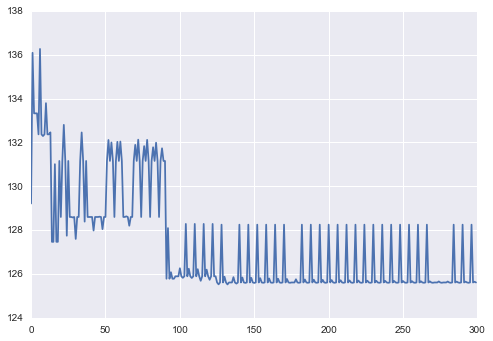

132 {'windowSize': 209, 'nWindows': 2, 'k': 2.25} 125.521668694


In [241]:
plt.plot(results)
plt.show()

bestindex = np.argmin(results)
print(bestindex, param_results[bestindex], results[bestindex])

In [189]:
print(np.arange(10).reshape(2,-1)[:,-2:4])

[[3]
 [8]]


In [32]:
# Let's just check a simple neural network.

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('normalize', StandardScaler()), #with_mean = True, with_std = True)),
                   ('neural', MLPRegressor(hidden_layer_sizes = (6), verbose = True, learning_rate_init = 10**-1.9, 
                                           max_iter = 350)) ]) #, learning_rate = 'adaptive')) ])
scores = - cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
print('Cross val score = ', scores.mean(), '+-', scores.std())

Iteration 1, loss = 2986116822.23651457
Iteration 2, loss = 2985294710.36466265
Iteration 3, loss = 2983860418.02899408
Iteration 4, loss = 2981752043.24776602
Iteration 5, loss = 2978894884.63106203
Iteration 6, loss = 2975303669.46468353
Iteration 7, loss = 2970754240.57777214
Iteration 8, loss = 2966027277.52307463
Iteration 9, loss = 2960737847.07124281
Iteration 10, loss = 2954817614.55259037
Iteration 11, loss = 2948600252.53936815
Iteration 12, loss = 2941521805.82580853
Iteration 13, loss = 2934291175.71326017
Iteration 14, loss = 2926852256.65638018
Iteration 15, loss = 2918420524.29668665
Iteration 16, loss = 2909768845.56676722
Iteration 17, loss = 2901366891.69754553
Iteration 18, loss = 2892061048.76210308
Iteration 19, loss = 2881929905.62242460
Iteration 20, loss = 2872091057.54651976
Iteration 21, loss = 2861633325.25839281
Iteration 22, loss = 2851025564.10757923
Iteration 23, loss = 2840394557.68098021
Iteration 24, loss = 2829172987.01492739
Iteration 25, loss = 2817

Iteration 1, loss = 7138313860.86401558
Iteration 2, loss = 7132593411.48067760
Iteration 3, loss = 7127232514.44857502
Iteration 4, loss = 7119085876.33787441
Iteration 5, loss = 7109251619.39457989
Iteration 6, loss = 7097666950.29242325
Iteration 7, loss = 7084160684.62523270
Iteration 8, loss = 7069568831.42622566
Iteration 9, loss = 7053820118.46400356
Iteration 10, loss = 7035971757.66490078
Iteration 11, loss = 7017460273.95276356
Iteration 12, loss = 6997075535.56021118
Iteration 13, loss = 6976714474.76372147
Iteration 14, loss = 6954465599.17945766
Iteration 15, loss = 6930429452.39121151
Iteration 16, loss = 6905740894.51911449
Iteration 17, loss = 6884488739.52881050
Iteration 18, loss = 6854241652.83516502
Iteration 19, loss = 6826102953.50436687
Iteration 20, loss = 6797358299.29878616
Iteration 21, loss = 6769479261.00911045
Iteration 22, loss = 6740598300.73690605
Iteration 23, loss = 6706563495.77351284
Iteration 24, loss = 6672838244.56517601
Iteration 25, loss = 6639

Iteration 11, loss = 4515839935.50704670
Iteration 12, loss = 4507028834.99466610
Iteration 13, loss = 4497890361.20531082
Iteration 14, loss = 4488256645.51621723
Iteration 15, loss = 4477728122.85527039
Iteration 16, loss = 4466666864.07724571
Iteration 17, loss = 4455638792.81875038
Iteration 18, loss = 4444093343.34141064
Iteration 19, loss = 4432185058.17986298
Iteration 20, loss = 4419622745.95320034
Iteration 21, loss = 4406870683.68307972
Iteration 22, loss = 4392934582.10162163
Iteration 23, loss = 4379765749.84084034
Iteration 24, loss = 4364732298.27262974
Iteration 25, loss = 4349741137.65052605
Iteration 26, loss = 4335163984.35130787
Iteration 27, loss = 4319148845.85030842
Iteration 28, loss = 4302154623.95718861
Iteration 29, loss = 4285552150.47170639
Iteration 30, loss = 4268620123.08406544
Iteration 31, loss = 4251524217.25666904
Iteration 32, loss = 4234096267.67297935
Iteration 33, loss = 4215144927.71070099
Iteration 34, loss = 4195727753.87424326
Iteration 35, lo

Iteration 210, loss = 124293107.01153493
Iteration 211, loss = 123757720.29972303
Iteration 212, loss = 123177087.88044465
Iteration 213, loss = 122274037.48397082
Iteration 214, loss = 121895063.83350658
Iteration 215, loss = 121592792.29494183
Iteration 216, loss = 120986351.49491724
Iteration 217, loss = 120547164.14876616
Iteration 218, loss = 120183281.58468807
Iteration 219, loss = 119906793.21687666
Iteration 220, loss = 119220436.58195485
Iteration 221, loss = 119111814.03694600
Iteration 222, loss = 118651678.02202776
Iteration 223, loss = 118690765.69036682
Iteration 224, loss = 118605356.52848397
Iteration 225, loss = 118134077.45873401
Iteration 226, loss = 117764953.84633027
Iteration 227, loss = 117711906.82699314
Iteration 228, loss = 117775363.73020022
Iteration 229, loss = 117405253.27917857
Iteration 230, loss = 117436359.95912799
Iteration 231, loss = 117092592.84458052
Iteration 232, loss = 116916970.32599714
Iteration 233, loss = 116873883.16402470
Iteration 234, l